# 데이터 분류
data_fail         : 실패시 모든 trial에 대한 success_times, fail_reason, 마지막 dec info(4개) 

          분류할 때 key가 됨

data_dt           : success step / x loc / x vel / theta loc / theta vel / I index / Wi / y / elig / Vi / xi elig / r hat

In [1]:
import sys
sys.path

['',
 'C:\\Program Files\\Python36\\python36.zip',
 'C:\\Program Files\\Python36\\DLLs',
 'C:\\Program Files\\Python36\\lib',
 'C:\\Program Files\\Python36',
 'C:\\Program Files\\Python36\\lib\\site-packages',
 'C:\\Program Files\\Python36\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\동현\\.ipython']

In [2]:
sys.path.insert(0, 'C:\\ProgramData\\Miniconda3\\lib\\site-packages')

In [1]:
# 패키지 
import numpy as np
import matplotlib.pyplot as plt
import time
import matplotlib.ticker as ticker

save_path = 'data/2d_inverted_pendulum_std1_ACE_'

In [2]:
# 함수 정의
# 가속도 계산
def acc_theta(force, theta_loc, theta_vel, x_vel):
    a = g*np.sin(theta_loc)  # radian인지, 각도인지 check
    b = np.cos(theta_loc) * (- force - m*l*theta_vel*theta_vel*np.sin(theta_loc) + uc*sgn(x_vel))/(mc+m)
    c = -up * theta_vel / (m*l)
    d = l*(4/3 - m*(np.cos(theta_loc))**2 / (mc + m))
    
    return (a + b + c)/d

def acc_x(force, theta_acc, theta_vel, theta_loc, x_vel):
    b = m*l*(theta_vel**2*np.sin(theta_loc) - theta_acc*np.cos(theta_loc))
    c = -uc*sgn(x_vel)
    
    return (force + b + c)/(mc + m)

# 실패했을 때 처벌
def failure_test(x_loc, theta_loc):
    
    if (range_failure_x[0] <= x_loc <= range_failure_x[1]) and (range_failure_theta[0] <= theta_loc <= range_failure_theta[1]):
        return 0
    
    else :
        return -1
    
# 실패 이유
# 실패 했을 때만 사용함
# x loc (0,1), theta loc (2,3)으로 표기 한다.
def fail_reason(x_loc, theta_loc):
    
    reason1 = -10
    reason2 = -10
    
    # x loc
    if x_loc < range_failure_x[0]:
        reason1 = 0
    
    elif x_loc > range_failure_x[1]:
        reason1 = 1
    
    # theta loc
    if theta_loc < range_failure_theta[0]:
        reason2 = 2
    
    elif theta_loc > range_failure_theta[1]:
        reason2 = 3
    
    # 두 이유 중 하나만 있을 때
    if ((reason1 + reason2) < 0):
        
        if reason1 > reason2 :
            return reason1
        else :
            return reason2
    
    # 두 이유 모두 작용할 때
    else :
        return reason1*10 + reason2
    
# 입력에 대한 Index, state 출력
def decoder(x_loc, x_vel, theta_loc, theta_vel):
    state = np.zeros((162))
  
    for ii, xx in enumerate(range_x_loc):
        index_x_loc = ii
        
        if x_loc < xx:
            break
        else : 
            index_x_loc += 1
            
    for ii, xx in enumerate(range_x_vel):
        index_x_vel = ii
        
        if x_vel < xx:
            break
        else : 
            index_x_vel += 1     
            
    for ii, xx in enumerate(range_theta_loc):
        index_theta_loc = ii
        
        if theta_loc < xx:
            break
            
        else : 
            index_theta_loc += 1
            
    for ii, xx in enumerate(range_theta_vel):
        index_theta_vel = ii
        
        if theta_vel < xx:
            break
            
        else : 
            index_theta_vel += 1

    # 162/3 = 54, 162/(3*3) = 18, 162/(3*3*6) = 3, 162/(3*3*6*3) = 1
    Index = 54*index_x_loc + 18*index_x_vel + 3*index_theta_loc + index_theta_vel
    
    # r=0 때만 state에 1 추가
    if failure_test(x_loc, theta_loc) == 0:
        state[Index] = 1
    
    return Index, state

def sgn(x):
    
    if x >= 0 :
        return 1
    else :
        return -1
    

In [1]:
# 상수 정의
dt = 1e-5
sigma = 0.01
alpha = 1000
beta = 0.5
delta = 0.9
# 이해를 돕기 위해 gamma = 1로 놓음 
gamma = 1
lamb = 0.8

g = 9.8
mc = 1
m = 0.1
l = 0.5
uc = 0.0005
up = 0.000002
max_count = 80000


# decoder index 계산 시
num_x_loc = 162/3
num_x_vel = 162/3/3
num_theta_loc = 162/3/3/6
num_theta_vel = 162/3/3/6/3

# 실패 범위
range_failure_x = [-2.4, 2.4]
range_failure_theta = [-12*np.pi/180, 12*np.pi/180]

# decoder 범위
range_x_loc = [-0.8, 0.8]
range_x_vel = [-0.5, 0.5]
range_theta_loc = np.array([-6, -1, 0, 1, 6], dtype=np.float64)
range_theta_vel = np.array([-50, 50], dtype=np.float64)

# radian으로 변경
range_theta_loc *= np.pi/180
range_theta_vel *= np.pi/180


In [4]:
# state array 만들기
# 각 state별 index 사전으로 보면 됨
# 각 state별로 나온 횟수 count도 함

dic_state_info = []

# index 정의
all_x_loc = [-1, 0, 1]
all_x_vel = [-1, 0, 1]
all_theta_loc = [-3, -2, -1, 1, 2, 3]
all_theta_vel = [-1, 0, 1]

# index 넣기
for i in all_x_loc:
    for ii in all_x_vel:
        for iii in all_theta_loc:
            for iiii in all_theta_vel:
                # 마지막(5열)은 count를 위한 공간
                dic_state_info.append([i, ii, iii, iiii, 0])
                

In [5]:
# data 배열
data_W = []
data_fail = []         # success_times, fail_reason, 마지막 dec info(4개) 
data_dt = []       # 모든 dt 간격으로의 정보

# 추가 데이터 분석
data_elig_dt = []
data_stateElig_dt = []
data_W_dt = []
data_V_dt = []

data_W0 = []
data_V0 = []

# 초기 weight 생성
W = np.zeros((162))
V = np.zeros((162))

# 학습 Loop

In [6]:
# total trial
total_trial_num = 5

for failure_count in range(total_trial_num):
    
    # 실패 후 초기화함.
    # 변수 초기화 (weight는 초기화하지 않음.)
    x_loc = 0
    x_vel = 0
    theta_loc = 0
    theta_vel = 0
    elig = np.zeros((162))
    
    # ACE 변수. 시간별로 필요하므로.
    state_elig = np.zeros((162))
    P1 = 0
    P0 = 0
    
    # decoder index
    Index, state = decoder(x_loc, x_vel, theta_loc, theta_vel)
    Indexes = dic_state_info[Index][0:4]

    
    # dt 간격으로 저장할 list 초기화
    d_dt = []
    success_step = 0
    
    d_W_dt = []
    d_V_dt = []
    d_elig_dt = []
    d_stateElig_dt = []

    # 전 weight와 후 weight를 비교하기 위해.
    # 데이터 저장 용
    W0 = W*1
    V0 = V*1
    
    # trial마다 같은 noise 주기 위해
    # np.random.seed(9001)
    
    # loop 시작
    while success_step < max_count:
        
        # ASE
        noise = np.random.normal(0, sigma)
        X = W[Index] + noise # noise는 gaussian dist.
        y = sgn(X)
        
        # t초의 카트 미는 힘 계산
        # 안전 범위 안에 있으면 y=0
        force = y * 10        
        
        # t+dt eligibility
        # elig = delta*elig + (1-delta)*y*state
        elig = delta*elig + (1-delta)*y*state

        
        # ACE
        # state eligibility
        state_elig  = lamb*state_elig + (1-lamb)*state
        
        # P(t) 계산
        # Probability
        P0 = np.sum(V*state)
        
        # t초의 data 저장, 매 dt마다.
        # 위치 계산되기 전에 저장한다.
        # r_hat은 나중에 계산 후 저장.
        d_dt.append([success_step, 
                     Indexes[0], Indexes[1], Indexes[2], Indexes[3], Index,
                     W[Index], y, elig[Index], 
                     V[Index], state_elig[Index]])
        
        dic_state_info[Index][4] += 1
        
        ####################### 시뮬레이션 t+dt update
        # 가속도 계산
        theta_acc = acc_theta(force, theta_loc, theta_vel, x_vel)
        x_acc = acc_x(force, theta_acc, theta_vel, theta_loc, x_vel)

        # 속도, 위치 계산
        # Euler's methods
        theta_vel += theta_acc*dt
        x_vel += x_acc*dt

        # 위치 update
        theta_loc += theta_vel*dt
        x_loc += x_vel*dt     
        
        #######################
        
        # decoder index
        # update된 state
        Index, state = decoder(x_loc, x_vel, theta_loc, theta_vel)
        Indexes = dic_state_info[Index][0:4]
        
        # reinforce 계산
        r = failure_test(x_loc, theta_loc)
        
        
        # 실패했을 때
        if r == -1:
            
            # r refine
            # P1 = 0 으로 취급.
            r_hat = r - P0
            
            # weight update
            W += alpha * r_hat * elig
            V += beta * r_hat * state_elig
            
            # end of while loop
            # fail count 출력
            print('failure {0}'.format(failure_count+1))
            
            # r_hat 저장
            d_dt[-1].append(r_hat)
            
            d_W_dt.append(W*1)
            d_V_dt.append(V*1)
            d_elig_dt.append(elig*1)
            d_stateElig_dt.append(state_elig*1)
            
            # while loop를 나간다.
            break
            
        # 실패하지 않았을 때
        else:
        
            # Probability
            P1 = np.sum(V*state)

            # r_hat(t)
            r_hat = r + gamma * P1 - P0
            
            # t+dt초 때의 weight update
            W += alpha * r_hat * elig
            V += beta * r_hat * state_elig
            
            # step count + 1
            success_step += 1
            
            # max_count 넘겼을 때 성공 출력하기
            if not(success_step < max_count) :
                print('success {0}'.format(failure_count+1))
            
            # r_hat 저장
            d_dt[-1].append(r_hat)
            
            d_W_dt.append(W*1)
            d_V_dt.append(V*1)
            d_elig_dt.append(elig*1)
            d_stateElig_dt.append(state_elig*1)
                
    
    # save data (data_dec_dt는 나중에 따로 계산)
    data_fail.append(np.array([failure_count, success_step, 
                               fail_reason(x_loc, theta_loc), y, Index,
                               Indexes[0], Indexes[1], Indexes[2], Indexes[3]]))
    data_dt.append(d_dt)
    data_W.append(W*1)      # array는 복사하려면 *1을 해줘야 하더라.
    
    data_W_dt.append(d_W_dt)
    data_V_dt.append(d_V_dt)
    data_W0.append(W0*1)
    data_V0.append(V0*1)
    
    data_elig_dt.append(d_elig_dt)
    data_stateElig_dt.append(d_stateElig_dt)
    
    # cpu 부담 경감
    time.sleep(0.001)
    
    

failure 1
failure 2
failure 3
failure 4
failure 5


In [7]:
# array로 만들어야 argsort를 쓸 수 있음
data_fail = np.array(data_fail)

# index 별 의미
# 0 : trial count
# 1 : success step
# 2 : fail reason
# 3 : 실패 했을 때 y
# 4 : i index(0 ~ 161)
# 5 ~ 8 : decoder state index(4 variable)

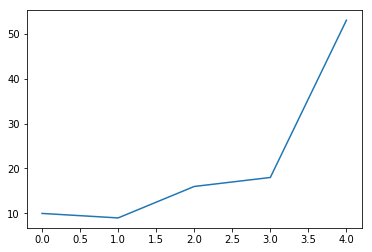

In [8]:
plt.plot(data_fail[:,1])
plt.show()

C:\Users\hyeon\AppData\Local\Continuum\miniconda3\lib\site-packages\numpy\lib\function_base.py:1128: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\hyeon\AppData\Local\Continuum\miniconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


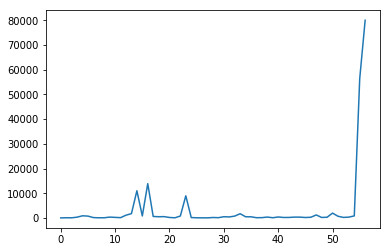

In [9]:
# success count plot
# 10개씩 평균

ave_success_count = []
for i in range(len(data_fail)):
    
    ave_success_count.append(np.average(data_fail[i*10 : (i+1)*10,1]))

plt.plot(ave_success_count)
# plt.ylim(ymin=0)
plt.show()

# Data 분석에 필요한 계산

Learning V, W

In [13]:
# data 분류 후 저장
# 계산 루프랑 분석 루프랑 분리함

data_nonzero_rHat_idx = []
data_list_i_idx = []  # 중복 없이 trial마다 I index를 저장
data_learning_V = []  # trial 마다 학습의 정도를 비교하기 위해
data_learning_W = []

# data_dt 의 데이터
# success step / x_loc / x_vel / theta_loc / theta_vel / I index / 
# Wi / y / elig / Vi / xi_elig / r_hat

for fc in range(len(data_dt)):
    
    # 분석할 데이터
    data_anal = np.array(data_dt[fc])
    
    # 중복 없이 먼저 나왔던 state 순서대로 들어간다.
    list_i_idx = []
    for i in data_anal[:,5]:
        i = int(i)

        try:
            # i가 list_i_idx에 없으면 오류가 나와서 except로 이동함
            list_i_idx.index(i)

        except:
            # 없으면 추가해준다.
            list_i_idx.append(int(i))
            
    data_list_i_idx.append(list_i_idx)

    
    ###################################
    # learning data 만들기    
    # 위에 중복 없앤 나왔던 state만 모은 list 활용
    d_learning_V = []
    d_learning_W = []
    
    # r hat (nonzero)만 골라내기
    # nonzero인 index만 들어감.
    dnrHi = np.nonzero(data_anal[:,-1])[0]
    
    for i in list_i_idx:
        d_l_V = []
        d_l_W = []

        # state index 넣기
        d_l_V.extend(dic_state_info[i][0:4])
        d_l_V.append(i)
        d_l_W.extend(dic_state_info[i][0:4])
        d_l_W.append(i)
    
        # 처음에 학습 전 데이터 먼저 넣기
        d_l_V.append(data_V0[fc][i])
        d_l_W.append(data_W0[fc][i])
        
        # Vi, Wi 넣기
        # r hat이 0이 아닐 때만 들어감
        for ii in dnrHi:
            d_l_V.append(data_V_dt[fc][ii][i])
            d_l_W.append(data_W_dt[fc][ii][i])

        d_learning_V.append(d_l_V)
        d_learning_W.append(d_l_W)
        
    data_learning_V.append(d_learning_V)
    data_learning_W.append(d_learning_W)
    data_nonzero_rHat_idx.append(dnrHi)
    


In [15]:
# trial 별로 data_learning_V 메모장으로 옮기기
# 액셀로 옮기기 위함

# 저장할 데이터
# data_learning_W 저장하려면 바꿔주면 됨.
save_data = data_learning_V
save_name = 'learning_V'

# 저장할 메모장 열기
f = open(save_path + save_name + ".txt", 'w')

# 액셀에서 수식으로 적으려고 비움.
data_list_learning = ['', '', '', '', '', '']
data_list_learning1 = ['x_loc', 'x_vel', 'theta_loc', 'theta_vel', 'I index', 'V']

# I index 까지의 길이
len_Iindex = data_list_learning1.index('I index') + 1

for i,x in enumerate(save_data):
    
    # 몇 번째 시도인지 쓰기
    f.write('f{0}'.format(i+1))
    
    # shift index 까지 띄우기
    f.write('\t'*len_Iindex)
    
    # shift index data 입력
    for ii in data_nonzero_rHat_idx[i]:
        # 현재 index
        now_idx = data_dt[i][ii][5]
        
        # 다음 index
        try :
            next_idx = data_dt[i][ii+1][5]
        
        # 다음 index가 없으면 Fail임.
        except(IndexError):
            next_idx = 'F'
        
        f.write('\t{0}->{1}'.format(now_idx, next_idx))
    
    # 한 줄 띄우기
    f.write('\n')
    
    # r hat 적을 곳까지 띄우기
    f.write('\t'*len_Iindex)
    
    # r hat data 입력
    for ii in data_nonzero_rHat_idx[i]:
        f.write('\t{0:.3f}'.format(data_dt[i][ii][-1]))
    
    # 한 줄 띄우기
    f.write('\n')
    
    # 전체 데이터 길이
    len_V = len(x[0])
  
    # data list 넣기
    # 마지막 것 제외
    for xx in data_list_learning[:len_Iindex]:
        f.write(str(xx) + '\t')
    
    # V의 크기만큼
    for ii in range(len_V - len_Iindex):
        f.write(str(ii) + '\t')
        
    f.write('\n')
    
    # learning 데이터 넣기
    # i 번째
    for xx in x:
        # state 별로 data 원소 넣기
        for xxx in xx:
            # 정수는 그냥 쓰고, 실수형은 소수점 3자리까지만 표시
            # 0이면 그냥 0 씀
            if (xxx != 0) and (type(xxx) == np.float64):
                f.write('{0:.3f}\t'.format(xxx))
            else :
                f.write(str(xxx) + '\t')
        
        # 한 state 다 썼으면 줄 띄우기
        f.write('\n')
            
    # i 번째 시도 다 썼으면 한 줄 띄우기
    f.write('\n')

# 다 썼으면 메모장 닫기
f.close()

# Graph plot

In [16]:
# color 정의
data_color = ['b', 'g', 'y', 'k', 'm', 'r', 'c']

10


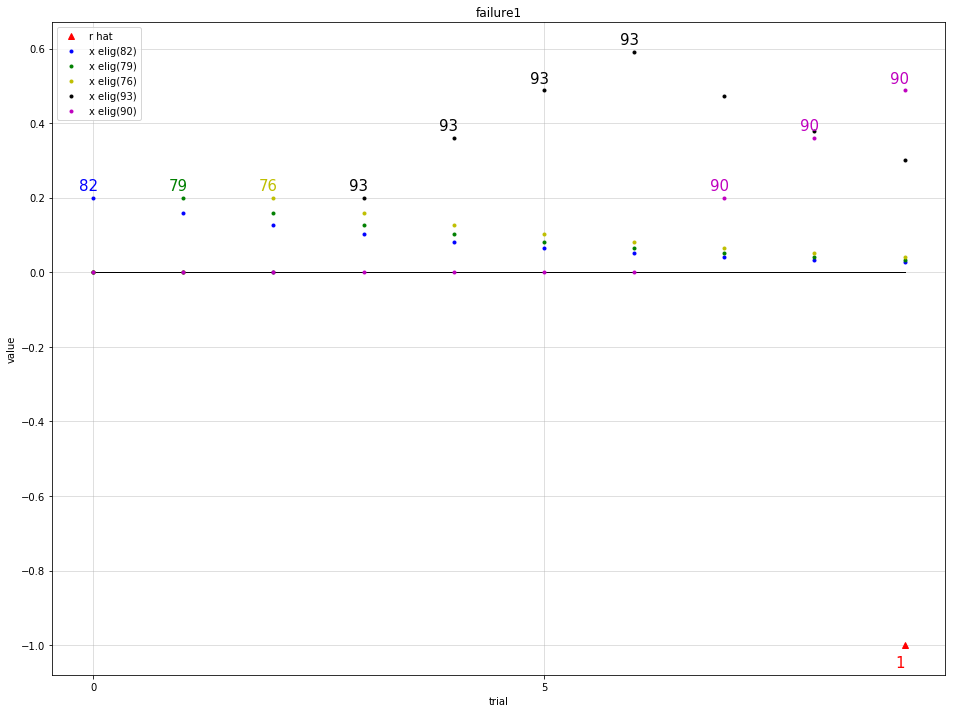

In [20]:
# r hat / x elig

# trial 선택
idx = 0
fig_size = (16, 12)
text_state_size = 15
text_legend_size = 10

# data 범위 설정
start_idx = 0
end_idx = 0

# 끝자락 데이터 더 잘 보이도록
start_idx -= 0.5
end_idx += 0.5

# x elig data
name_data = 'x elig'
anal_data = np.array(data_stateElig_dt[idx])

# 전체 data 크기
print(len(data_dt[idx]))

fig, ax = plt.subplots(figsize = fig_size)

# title
plt.title('failure{0}'.format(idx+1))

# 기준 선
plt.plot([0, len(data_dt[idx])-1], [0,0], '-k', linewidth=1)

# r hat
label_bool = True      # label을 하나만 넣기 위한 변수
reinf_count = 0         # trial 안에서 몇 번째 강화인지

# r hat data
for i in data_nonzero_rHat_idx[idx]:
    
    # r hat data
    x = data_dt[idx][i][-1]
    
    # data 점 찍기
    # 처음 들어가는 데이터만 label 넣음. 안 그러면 label 여러 개가 들어가짐.
    if label_bool:
        plt.plot(i, x, '^r', label='r hat')
        plt.legend(prop={'size': text_legend_size})
        label_bool = False
        
    else :
        plt.plot(i, x, '^r')
        
    # 숫자 표기
    reinf_count += 1
    ax.annotate(str(reinf_count), xy=(i, x), xytext=(i - 0.1, x - 0.06), 
                color='r', size=text_state_size)
    
# elig
# graph plot
for i,x in enumerate(data_list_i_idx[idx]):
    plt.plot(anal_data[:,x], '.' + data_color[i%len(data_color)], 
             label='{0}({1})'.format(name_data, x), 
             linewidth = 0.1)
    plt.legend(prop={'size': text_legend_size})

# I index를 넣어서 각 시간에 존재하는 state의 x elig만 찾는다.
# index 로 넣어줄 것이므로 int로 만듦
eachTime_state = np.array(data_dt[idx], dtype=np.int32)[:,5]

for i,x in enumerate(eachTime_state):
    
    # 같은 state는 색깔 고정으로 나오도록
    unique_idx = data_list_i_idx[idx].index(x)
    
    # state 숫자 표기
    data_elig = anal_data[i,x]
    ax.annotate(str(x), xy=(i, data_elig), 
                xytext=(i - 0.16, data_elig + 0.02), 
                color=data_color[unique_idx%len(data_color)], size=text_state_size)

# grid 간격 조정
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))

# Or if you want different settings for the grids:
ax.grid(which='major', alpha=0.5)

plt.xlabel('trial')
plt.ylabel('value')

# 범위 지정 했을 때만 
if start_idx+1 != end_idx:
    plt.xlim(xmin=start_idx, xmax=end_idx)
    
plt.show()

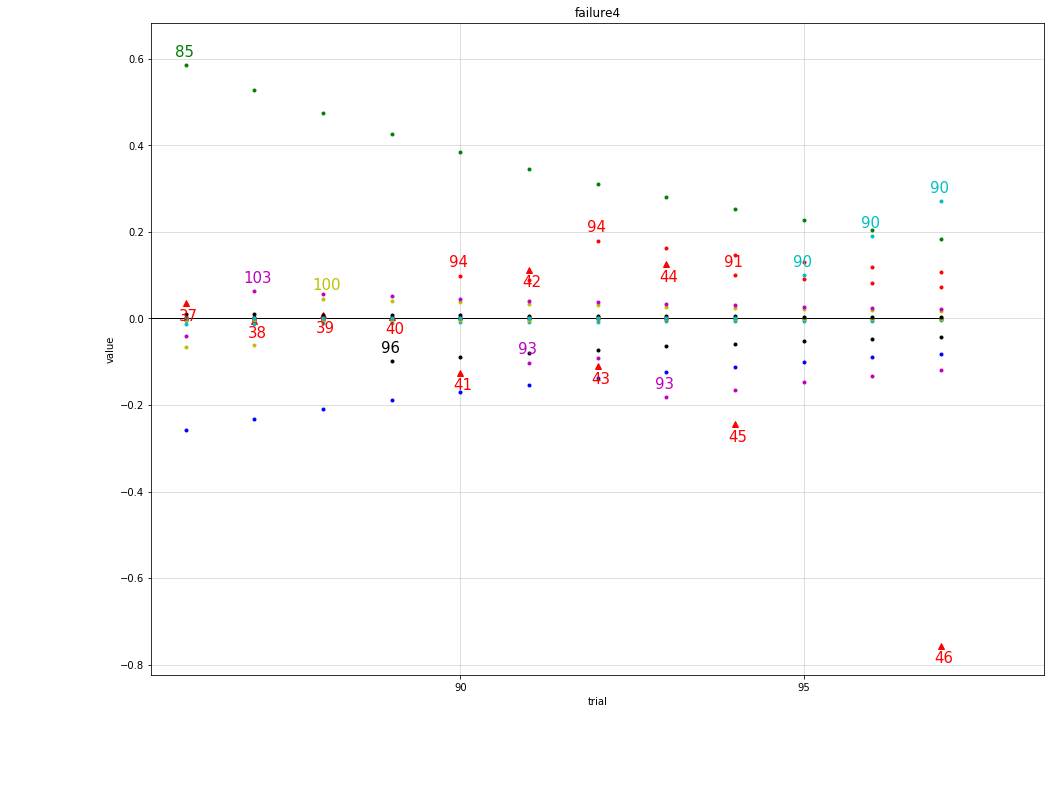

In [65]:
# r hat / elig

# elig data
anal_data = np.array(data_elig_dt[idx])
name_data = 'elig'

fig, ax = plt.subplots(figsize = fig_size)

# title
plt.title('failure{0}'.format(idx+1))

# 기준 선
plt.plot([0, len(data_dt[idx])-1], [0,0], '-k', linewidth=1)

# r hat
label_bool = True      # label을 하나만 넣기 위한 변수
reinf_count = 0         # trial 안에서 몇 번째 강화인지

# r hat data
for i in data_nonzero_rHat_idx[idx]:
    
    # r hat data
    x = data_dt[idx][i][-1]
    
    # data 점 찍기
    # 처음 들어가는 데이터만 label 넣음. 안 그러면 label 여러 개가 들어가짐.
    if label_bool:
        plt.plot(i, x, '^r', label='r hat')
        #plt.legend(prop={'size': text_legend_size})
        label_bool = False
        
    else :
        plt.plot(i, x, '^r')
        
    # 숫자 표기
    reinf_count += 1
    ax.annotate(str(reinf_count), xy=(i, x), xytext=(i - 0.1, x - 0.04), 
                color='r', size=text_state_size)
    
# elig
# graph plot
for i,x in enumerate(data_list_i_idx[idx]):
    plt.plot(anal_data[:,x], '.' + data_color[i%len(data_color)], 
             label='{0}({1})'.format(name_data, x), 
             linewidth = 0.1)
    #plt.legend(prop={'size': text_legend_size})

# I index를 넣어서 각 시간에 존재하는 state의 x elig만 찾는다.
# index 로 넣어줄 것이므로 int로 만듦
eachTime_state = np.array(data_dt[idx], dtype=np.int32)[:,5]

for i,x in enumerate(eachTime_state):
    
    # 같은 state는 색깔 고정으로 나오도록
    unique_idx = data_list_i_idx[idx].index(x)
    
    # state 숫자 표기
    data_elig = anal_data[i,x]
    ax.annotate(str(x), xy=(i, data_elig), 
                xytext=(i - 0.16, data_elig + 0.02), 
                color=data_color[unique_idx%len(data_color)], size=text_state_size)
    
# grid 간격 조정
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))

# Or if you want different settings for the grids:
ax.grid(which='major', alpha=0.5)

plt.xlabel('trial')
plt.ylabel('value')
plt.xlim(xmin=start_idx, xmax=end_idx)
plt.show()

# data 저장

In [11]:
# dt 간격 데이터 메모장으로 옮기기
# simulation 구현 위함

# 저장할 메모장 열기
f = open(save_path + "dt.txt", 'w')

data_list_dt = ['', '', '', '', '', '',
                'Wi', 'y', 'ei', 'Vi', 'x_ei', 'r_hat']
data_list_dt1 = ['step', 'x_loc', 'x_vel', 'theta_loc', 'theta_vel', 'I index',
                'Wi', 'y', 'ei', 'Vi', 'x_ei', 'r_hat']

for i,x in enumerate(data_dt):
    
    # 몇 번째 시도인지 쓰기
    f.write('f{0} \n'.format(i+1))
    
    # data list 넣기
    for xx in data_list_dt:
        f.write(xx + '\t')
    f.write('\n')
        
    # dt 데이터 넣기
    # i 번째 시도
    for xx in x:
        # success step 별로 data 원소 넣기
        for xxx in xx:
            # 정수는 그냥 쓰고, 실수형은 소수점 3자리까지만 표시
            # 0이면 그냥 0 씀
            if (xxx != 0) and (type(xxx) == np.float64):
                f.write('{0:.3f}\t'.format(xxx))
            else :
                f.write(str(xxx) + '\t')
        
        # 한 success step 다 썼으면 줄 띄우기
        f.write('\n')
            
    # i 번째 시도 다 썼으면 두 줄 띄우기
    f.write('\n\n')

# 다 썼으면 메모장 닫기
f.close()

In [29]:
# data_fail 저장하기

# 저장할 메모장 열기
f = open(save_path + "fail.txt", 'w')

data_list_fail = ['trial', 'step', 'f_reason', 'last y', 'I index',
                      'x_loc', 'x_vel', 'theta_loc', 'theta_vel']

# data list 넣기
for xx in data_list_fail:
    f.write(xx + '\t')
f.write('\n')

# fail 데이터 넣기
for i,x in enumerate(data_fail):
    for xx in x:
        f.write(str(xx) + '\t')
        
    # 줄 띄우기
    f.write('\n')

# 다 썼으면 메모장 닫기
f.close()

In [26]:
# npy로 저장
np.save(save_path + 'fail', data_fail)